20170608
/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/pyrite/ERA5/raw/ERA-5_N32_N36_W120_W115_20170608_14.grb
32
(17, 21)
[0.    0.001]
[0.    0.001]
[0.    0.001]
[0.    0.001]
[0.    0.001]
[0.    0.001]
[nan, nan, nan, nan]


/Users/caoy0a/Documents/development/python/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


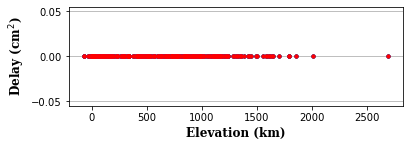

32
32
[0.07771477 0.00055156]
[0.07771484 0.00055156]
[0.07771485 0.00055156]
[0.07771485 0.00055156]
[0.07771485 0.00055156]
[0.07771485 0.00055156]
[0.8945106454609698, 0.9905451447516314, 0.9903051868299955, 0.9986453649066025]


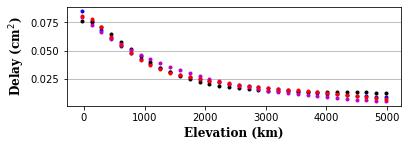

In [66]:
import os
import sys
import numpy as np
import argparse
from pyrite import _utils as ut
import glob
import matplotlib.pyplot as plt
from gigpy import elevation_models

from scipy.optimize import leastsq
from scipy.stats.stats import pearsonr
#### define dicts for model/residual/initial values ###############

model_dict = {'linear': elevation_models.linear_elevation_model,
                      'onn': elevation_models.onn_elevation_model,
                      'onn_linear': elevation_models.onn_linear_elevation_model,
                      'exp': elevation_models.exp_elevation_model,
                      'exp_linear': elevation_models.exp_linear_elevation_model}

residual_dict = {'linear': elevation_models.residuals_linear,
                      'onn': elevation_models.residuals_onn,
                      'onn_linear': elevation_models.residuals_onn_linear,
                      'exp': elevation_models.residuals_exp,
                      'exp_linear': elevation_models.residuals_exp_linear}

initial_dict = {'linear': elevation_models.initial_linear,
                      'onn': elevation_models.initial_onn,
                      'onn_linear': elevation_models.initial_onn_linear,
                      'exp': elevation_models.initial_exp,
                      'exp_linear': elevation_models.initial_exp_linear}

para_numb_dict = {'linear': 2,
                  'onn' : 3,
                  'onn_linear':4,
                  'exp':2,
                  'exp_linear':3}

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

k0 = 0
cdic = ut.initconst()
raw_dir = '/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/pyrite/ERA5/raw'
date_list = ut.read_hdf5(era5_file,datasetName = 'date')[0]
date_list = date_list.astype('U13')
date0 = date_list[k0]
print(date0)
fname0 = glob.glob(raw_dir + '/ERA*' + date0 + '*')[0]
print(fname0)
lvls,latlist,lonlist,gph,tmp,vpr = ut.get_ecmwf('ERA5',fname0,cdic, humidity='Q')     
# Make a height scale
hgt = np.linspace(cdic['minAltP'], gph.max().round(), cdic['nhgt'])
# Interpolate pressure, temperature and Humidity of hgt
[Pi,Ti,Vi] = ut.intP2H(lvls, hgt, gph, tmp, vpr, cdic)
# Calculate the delays
[DDry,DWet] = ut.PTV2del(Pi,Ti,Vi,hgt,cdic)

hgt0 = hgt.copy()
idx0 = np.where(((-100<hgt0) & (hgt0 < 5000)))
hgt00 = hgt0[idx0]

hgt0 = list(hgt0)
dd0 = DDry.copy()
dw0 = DWet.copy()
dt0 = dd0 + dw0

dd00 = dd0[:,:,idx0]
dw00 = dw0[:,:,idx0] 
dd00 = dd00.flatten()
dw00 = dw00.flatten()
dt00 = dd00 + dw00

print(len(hgt00))
nk = len(hgt00)

mdd = np.zeros((nk,),dtype = np.float32)
mdw = np.zeros((nk,),dtype = np.float32)
mdt = np.zeros((nk,),dtype = np.float32)

for i in range(nk):
    mdd[i] = np.mean(dd0[:,:,hgt0.index(hgt00[i])])
    mdw[i] = np.mean(dw0[:,:,hgt0.index(hgt00[i])])
    mdt[i] = np.mean(dt0[:,:,hgt0.index(hgt00[i])])
    
hgt_all = np.ones((DWet.shape),dtype = np.float32)
for i in range(hgt_all.shape[2]):
    hgt_all[:,:,i] = hgt_all[:,:,i] * hgt[i]
hgt_all_sample = hgt_all[:,:,idx0]
hgt_all_sample = hgt_all_sample.flatten()





era5_file = '/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/era5_sample.h5'

wdelay = ut.read_hdf5(era5_file,datasetName = 'wetDelay')[0]
ddelay = ut.read_hdf5(era5_file,datasetName = 'dryDelay')[0]
tdelay = ut.read_hdf5(era5_file,datasetName = 'totDelay')[0]

dem = ut.read_hdf5(era5_file,datasetName = 'height')[0]
print(dem.shape)
x00 = dem.flatten()
x0 = x00[x00!=0]
yw = wdelay[k0,:,:]
yw = yw.flatten()
yw = yw[x00!=0]

yd = ddelay[k0,:,:]
yd = yd.flatten()
yd = yd[x00!=0]

yt = tdelay[k0,:,:]
yt = yt.flatten()
yt = yt[x00!=0]

fig = plt.figure()
ax = fig.add_subplot(211)

y0 = yt
#ax.plot(x0, y0, 'ro',label='WNVCE-based variances',fillstyle='none')
#ax.plot(x0, yw, 'r.')
#ax.plot(x0, yd, 'g.')
ax.plot(x0, y0, 'b.')
ax.yaxis.grid()

### Onn model
model = 'onn'
initial_function = initial_dict[model]
elevation_function = model_dict[model]
residual_function = residual_dict[model]


p0 = initial_function(x0,y0)
plsq = leastsq(residual_function,p0,args = (x0,y0))

turb = y0 - elevation_function(plsq[0],x0)
corr_onn, _ = pearsonr(y0, elevation_function(plsq[0],x0))
y0_fit = elevation_function(plsq[0],x0)
ax.plot(x0, y0_fit, 'k.')


### linear model
model = 'linear'
initial_function = initial_dict[model]
elevation_function = model_dict[model]
residual_function = residual_dict[model]


p0 = initial_function(x0,y0)
plsq = leastsq(residual_function,p0,args = (x0,y0))

turb = y0 - elevation_function(plsq[0],x0)
corr_linear, _ = pearsonr(y0, elevation_function(plsq[0],x0))
y0_fit = elevation_function(plsq[0],x0)
ax.plot(x0, y0_fit, 'g.')


### onn_linear model
model = 'exp'
initial_function = initial_dict[model]
elevation_function = model_dict[model]
residual_function = residual_dict[model]


p0 = initial_function(x0,y0)
plsq = leastsq(residual_function,p0,args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])


turb = y0 - elevation_function(plsq[0],x0)
corr_exp, _ = pearsonr(y0, elevation_function(plsq[0],x0))
y0_fit = elevation_function(plsq[0],x0)
ax.plot(x0, y0_fit, 'm.')


### onn_linear model
model = 'onn_linear'
initial_function = initial_dict[model]
elevation_function = model_dict[model]
residual_function = residual_dict[model]


p0 = initial_function(x0,y0)
plsq = leastsq(residual_function,p0,args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])

turb = y0 - elevation_function(plsq[0],x0)
corr_onn_linear, _ = pearsonr(y0, elevation_function(plsq[0],x0))
y0_fit = elevation_function(plsq[0],x0)
ax.plot(x0, y0_fit, 'r.')


corr = [corr_linear,corr_onn,corr_exp,corr_onn_linear]

print(corr)
plt.xlabel('Elevation (km)', fontdict=font)
plt.ylabel('Delay (cm$^2$)', fontdict=font)
plt.show()



####################### plot all
fig = plt.figure()
ax = fig.add_subplot(212)

#x0 = hgt_all_sample
#y0 = dw00

x0 = hgt00
y0 = mdw
print(len(x0))
print(len(y0))
#ax.plot(x0, y0, 'ro',label='WNVCE-based variances',fillstyle='none')
#ax.plot(x0, yw, 'r.')
#ax.plot(x0, yd, 'g.')
ax.plot(x0, y0, 'b.')
ax.yaxis.grid()

### Onn model
model = 'onn'
initial_function = initial_dict[model]
elevation_function = model_dict[model]
residual_function = residual_dict[model]


p0 = initial_function(x0,y0)
plsq = leastsq(residual_function,p0,args = (x0,y0))

turb = y0 - elevation_function(plsq[0],x0)
corr_onn, _ = pearsonr(y0, elevation_function(plsq[0],x0))
y0_fit = elevation_function(plsq[0],x0)
ax.plot(x0, y0_fit, 'k.')


### linear model
model = 'linear'
initial_function = initial_dict[model]
elevation_function = model_dict[model]
residual_function = residual_dict[model]


p0 = initial_function(x0,y0)
plsq = leastsq(residual_function,p0,args = (x0,y0))

turb = y0 - elevation_function(plsq[0],x0)
corr_linear, _ = pearsonr(y0, elevation_function(plsq[0],x0))
y0_fit = elevation_function(plsq[0],x0)
#ax.plot(x0, y0_fit, 'g.')


### onn_linear model
model = 'exp'
initial_function = initial_dict[model]
elevation_function = model_dict[model]
residual_function = residual_dict[model]


p0 = initial_function(x0,y0)
plsq = leastsq(residual_function,p0,args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
print(plsq[0])


turb = y0 - elevation_function(plsq[0],x0)
corr_exp, _ = pearsonr(y0, elevation_function(plsq[0],x0))
y0_fit = elevation_function(plsq[0],x0)
ax.plot(x0, y0_fit, 'm.')
#

### onn_linear model
model = 'onn_linear'
initial_function = initial_dict[model]
elevation_function = model_dict[model]
residual_function = residual_dict[model]


p0 = initial_function(x0,y0)
plsq = leastsq(residual_function,p0,args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#print(plsq[0])
plsq = leastsq(residual_function,plsq[0],args = (x0,y0))


turb = y0 - elevation_function(plsq[0],x0)
corr_onn_linear, _ = pearsonr(y0, elevation_function(plsq[0],x0))
y0_fit = elevation_function(plsq[0],x0)
ax.plot(x0, y0_fit, 'r.')


corr = [corr_linear,corr_onn,corr_exp,corr_onn_linear]

print(corr)
plt.xlabel('Elevation (km)', fontdict=font)
plt.ylabel('Delay (cm$^2$)', fontdict=font)
plt.show()


